In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# 定义Add & Norm层
class AddNorm(nn.Module):
    def __init__(self, hidden_dim):
        super(AddNorm, self).__init__()
        self.norm = nn.LayerNorm(hidden_dim)

    def forward(self, x, residual):
        return self.norm(x + residual)

# 定义Feed Forward层
class FeedForward(nn.Module):
    def __init__(self, hidden_dim, ff_dim):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(hidden_dim, ff_dim)
        self.linear2 = nn.Linear(ff_dim, hidden_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

# 定义Multi-Head Attention层
class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.head_dim = hidden_dim // num_heads

        self.query = nn.Linear(hidden_dim, hidden_dim)
        self.key = nn.Linear(hidden_dim, hidden_dim)
        self.value = nn.Linear(hidden_dim, hidden_dim)

        self.fc = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        Q = self.query(query).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.key(key).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.value(value).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)

        energy = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.head_dim)

        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)

        attention = torch.softmax(energy, dim=-1)

        x = torch.matmul(attention, V).transpose(1, 2).contiguous().view(batch_size, -1, self.hidden_dim)
        x = self.fc(x)

        return x

# 定义Encoder层
class EncoderLayer(nn.Module):
    def __init__(self, hidden_dim, num_heads, ff_dim):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(hidden_dim, num_heads)
        self.ff = FeedForward(hidden_dim, ff_dim)
        self.norm1 = AddNorm(hidden_dim)
        self.norm2 = AddNorm(hidden_dim)

    def forward(self, x, mask=None):
        residual = x
        x = self.self_attn(x, x, x, mask)
        x = self.norm1(x, residual)

        residual = x
        x = self.ff(x)
        x = self.norm2(x, residual)

        return x

# 定义Decoder层
class DecoderLayer(nn.Module):
    def __init__(self, hidden_dim, num_heads, ff_dim):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(hidden_dim, num_heads)
        self.cross_attn = MultiHeadAttention(hidden_dim, num_heads)
        self.ff = FeedForward(hidden_dim, ff_dim)
        self.norm1 = AddNorm(hidden_dim)
        self.norm2 = AddNorm(hidden_dim)
        self.norm3 = AddNorm(hidden_dim)

    def forward(self, x, enc_outputs, src_mask=None, tgt_mask=None):
        residual = x
        x = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x, residual)

        residual = x
        x = self.cross_attn(x, enc_outputs, enc_outputs, src_mask)
        x = self.norm2(x, residual)

        residual = x
        x = self.ff(x)
        x = self.norm3(x, residual)

        return x
class PositionalEncoding(nn.Module):
    def __init__(self, hidden_dim, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, hidden_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, hidden_dim, 2).float() * (-np.log(10000.0) / hidden_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x

# 定义Transformer模型
class Transformer(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_heads, num_layers, ff_dim):
        super(Transformer, self).__init__()
        self.input_embedding = nn.Linear(input_dim, hidden_dim)
        self.pos_encoding = PositionalEncoding(hidden_dim)
        self.output_embedding = nn.Linear(hidden_dim, output_dim)

        self.encoder_layers = nn.ModuleList([EncoderLayer(hidden_dim, num_heads, ff_dim) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(hidden_dim, num_heads, ff_dim) for _ in range(num_layers)])

    def forward(self, src, tgt_mask=None):
        src_embed = self.input_embedding(src)
        src_embed = self.pos_encoding(src_embed)

        enc_outputs = src_embed
        for enc_layer in self.encoder_layers:
            enc_outputs = enc_layer(enc_outputs)

        dec_outputs = enc_outputs
        for dec_layer in self.decoder_layers:
            dec_outputs = dec_layer(dec_outputs, enc_outputs, tgt_mask=tgt_mask)

        outputs = self.output_embedding(dec_outputs[:, -1, :])
        return outputs


In [2]:
# 定义Transformer模型
'''
class Transformer(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_heads, num_layers, ff_dim):
        super(Transformer, self).__init__()
        self.input_embedding = nn.Linear(input_dim, hidden_dim)
        self.output_embedding = nn.Linear(hidden_dim, output_dim)

        self.encoder_layers = nn.ModuleList([EncoderLayer(hidden_dim, num_heads, ff_dim) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(hidden_dim, num_heads, ff_dim) for _ in range(num_layers)])

    def forward(self, src, tgt_mask=None):
        src_embed = self.input_embedding(src)

        enc_outputs = src_embed
        for enc_layer in self.encoder_layers:
            enc_outputs = enc_layer(enc_outputs)

        dec_outputs = enc_outputs
        for dec_layer in self.decoder_layers:
            dec_outputs = dec_layer(dec_outputs, enc_outputs, tgt_mask=tgt_mask)

        outputs = self.output_embedding(dec_outputs[:, -1, :])
        return outputs
        '''

'\nclass Transformer(nn.Module):\n    def __init__(self, input_dim, hidden_dim, output_dim, num_heads, num_layers, ff_dim):\n        super(Transformer, self).__init__()\n        self.input_embedding = nn.Linear(input_dim, hidden_dim)\n        self.output_embedding = nn.Linear(hidden_dim, output_dim)\n\n        self.encoder_layers = nn.ModuleList([EncoderLayer(hidden_dim, num_heads, ff_dim) for _ in range(num_layers)])\n        self.decoder_layers = nn.ModuleList([DecoderLayer(hidden_dim, num_heads, ff_dim) for _ in range(num_layers)])\n\n    def forward(self, src, tgt_mask=None):\n        src_embed = self.input_embedding(src)\n\n        enc_outputs = src_embed\n        for enc_layer in self.encoder_layers:\n            enc_outputs = enc_layer(enc_outputs)\n\n        dec_outputs = enc_outputs\n        for dec_layer in self.decoder_layers:\n            dec_outputs = dec_layer(dec_outputs, enc_outputs, tgt_mask=tgt_mask)\n\n        outputs = self.output_embedding(dec_outputs[:, -1, :])\n 

In [3]:
# 检查是否有可用的GPU
#device = torch.device('cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:

# 设置模型参数
input_dim = 19
hidden_dim = 128
output_dim = 1
num_heads = 8
num_layers = 6
ff_dim = 512

# 创建模型实例
model = Transformer(input_dim, hidden_dim, output_dim, num_heads, num_layers, ff_dim)
model.to(device)

Transformer(
  (input_embedding): Linear(in_features=19, out_features=128, bias=True)
  (pos_encoding): PositionalEncoding()
  (output_embedding): Linear(in_features=128, out_features=1, bias=True)
  (encoder_layers): ModuleList(
    (0): EncoderLayer(
      (self_attn): MultiHeadAttention(
        (query): Linear(in_features=128, out_features=128, bias=True)
        (key): Linear(in_features=128, out_features=128, bias=True)
        (value): Linear(in_features=128, out_features=128, bias=True)
        (fc): Linear(in_features=128, out_features=128, bias=True)
      )
      (ff): FeedForward(
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (relu): ReLU()
      )
      (norm1): AddNorm(
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
      (norm2): AddNorm(
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
    )
    (1): Encode

In [23]:
import pandas as pd
data = pd.read_csv('tmp2.csv')
#data_stock=data[data.name=='万科A']

features = ['company_id','date','open', 'close', 'high', 'low', 'volume', 'money_netflow', 'money_inflow', 'money_outflow',
       'net_inflow_rate', 'list_sector', 'CPI', '无风险利率',
       'total_market_cap', 'float_market_cap', 'pe_ttm', 'pb',
       'dividend_yield_ratio', 'major_id', 'minor_id',
       'change_ratio']
data = data[features]
#data=data.iloc[0:10000,:]
#data=data[features]

In [6]:
from sklearn.preprocessing import MinMaxScaler
scale_need_cols = [ 'open', 'close', 'high', 'low', 'volume', 'money_netflow', 'money_inflow', 'money_outflow',
       'net_inflow_rate', 'CPI', '无风险利率',
       'total_market_cap', 'float_market_cap', 'pe_ttm', 'pb',
       'dividend_yield_ratio',
       'change_ratio']
# 创建MinMaxScaler对象
scaler = MinMaxScaler(feature_range=(0, 1))
data.loc[:, scale_need_cols] = scaler.fit_transform(data[scale_need_cols])

d:\anaconda\envs\d2l\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [7]:
import numpy as np

def create_dataset(data, look_back=5):
    X, Y = [], []
    for i in range(len(data) - look_back - 1):
        X.append(data[i:(i + look_back), :-1])
        Y.append(data[i + look_back, -1])
    return np.array(X), np.array(Y)

In [8]:
look_back = 5
X, Y = create_dataset(data.values, look_back)
#X, Y = create_dataset(data.values, look_back)
# 划分训练集和测试集
train_size = int(len(X) * 0.7)
X_train, Y_train = X[:train_size], Y[:train_size]
X_test, Y_test = X[train_size:], Y[train_size:]

In [9]:
'''
from transformers import BertTokenizer
def tokenize_and_combine(data):
    text_data = data[:, :, 0]
    numeric_data = data[:, :, 1:].astype(float)
    
    # 创建中文BERT tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
    
    # 对文本部分进行分词和编码
    encoded_text = []
    max_length = 10  # 指定一个固定的最大长度
    for text_batch in text_data:
        encoded_batch = tokenizer.batch_encode_plus(
            text_batch.tolist(),
            add_special_tokens=False,
            padding='max_length',
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        )
        encoded_text.append(encoded_batch['input_ids'])
    
    encoded_text = torch.stack(encoded_text)
    
    # 将数值部分转换为PyTorch张量
    numeric_tensor = torch.tensor(numeric_data, dtype=torch.float)
    
    # 组合编码后的文本部分和数值部分
    combined_tensor = torch.cat((encoded_text, numeric_tensor), dim=-1)
    
    return combined_tensor
'''

"\nfrom transformers import BertTokenizer\ndef tokenize_and_combine(data):\n    text_data = data[:, :, 0]\n    numeric_data = data[:, :, 1:].astype(float)\n    \n    # 创建中文BERT tokenizer\n    tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')\n    \n    # 对文本部分进行分词和编码\n    encoded_text = []\n    max_length = 10  # 指定一个固定的最大长度\n    for text_batch in text_data:\n        encoded_batch = tokenizer.batch_encode_plus(\n            text_batch.tolist(),\n            add_special_tokens=False,\n            padding='max_length',\n            truncation=True,\n            max_length=max_length,\n            return_tensors='pt'\n        )\n        encoded_text.append(encoded_batch['input_ids'])\n    \n    encoded_text = torch.stack(encoded_text)\n    \n    # 将数值部分转换为PyTorch张量\n    numeric_tensor = torch.tensor(numeric_data, dtype=torch.float)\n    \n    # 组合编码后的文本部分和数值部分\n    combined_tensor = torch.cat((encoded_text, numeric_tensor), dim=-1)\n    \n    return combined_tensor\n"

In [10]:
#x_train=tokenize_and_combine(X_train)

In [11]:
#x_test=tokenize_and_combine(X_test)

In [12]:
def directional_accuracy(actual, predicted):
    actual_diff = np.diff(actual)
    predicted_diff = np.diff(predicted)
    return np.mean(np.sign(actual_diff) == np.sign(predicted_diff))

In [13]:
# 训练模型
from sklearn.metrics import mean_absolute_error, mean_squared_error
def train_model(model, optimizer, criterion, train_src, train_tgt, val_src, val_tgt, num_epochs, batch_size, patience, convergence_threshold):
    best_val_loss = float('inf')
    best_model = None
    epochs_without_improvement = 0
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        # 训练模式
        model.train()
        epoch_train_loss = 0
        for i in range(0, len(train_src), batch_size):
            batch_src = train_src[i:i+batch_size]
            batch_tgt = train_tgt[i:i+batch_size]

            optimizer.zero_grad()
            outputs = model(batch_src)
            loss = criterion(outputs.view(-1), batch_tgt.view(-1))
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        # 评估模式
        model.eval()
        with torch.no_grad():
            train_outputs = model(train_src)
            val_outputs = model(val_src)

            train_loss = criterion(train_outputs.view(-1), train_tgt.view(-1))
            val_loss = criterion(val_outputs.view(-1), val_tgt.view(-1))

            train_mae = mean_absolute_error(train_tgt, train_outputs.numpy().flatten())
            val_mae = mean_absolute_error(val_tgt, val_outputs.numpy().flatten())
            
            train_rmse = np.sqrt(mean_squared_error(train_tgt, train_outputs.numpy().flatten()))
            val_rmse = np.sqrt(mean_squared_error(val_tgt, val_outputs.numpy().flatten()))

            train_da = directional_accuracy(train_tgt, train_outputs.numpy().flatten())
            val_da = directional_accuracy(val_tgt, val_outputs.numpy().flatten())
        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.8f}, Train MAE: {train_mae:.8f}, Train RMSE: {train_rmse:.8f}, Train DA: {train_da:.8f}, Val Loss: {val_loss.item():.8f}, Val MAE: {val_mae:.8f}, Val RMSE: {val_rmse:.8f}, Val DA: {val_da:.8f}")
        if len(train_losses) > patience:
            recent_train_losses = train_losses[-patience:]
            if max(recent_train_losses) - min(recent_train_losses) < convergence_threshold:
                print(f"Training stopped at epoch {epoch+1} due to loss convergence.")
                return
        '''if best_val_loss-val_loss.item()>1e-7:
            best_val_loss = val_loss.item()
            best_model = model.state_dict()
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch+1}. Best Val Loss: {best_val_loss:.9f}")
            model.load_state_dict(best_model)
            return'''

# 准备训练和验证数据
train_src_data = X_train
train_tgt_data = Y_train
val_src_data = X_test
val_tgt_data = Y_test

train_src_tensor = torch.tensor(train_src_data,dtype=torch.float32,device=device)
#train_src_tensor = train_src_data.clone().detach().to(device)

train_tgt_tensor = torch.tensor(train_tgt_data,dtype=torch.float32,device=device)
val_src_tensor = torch.tensor(val_src_data,dtype=torch.float32,device=device)
#val_src_tensor = val_src_data.clone().detach().to(device)

val_tgt_tensor = torch.tensor(val_tgt_data,dtype=torch.float32,device=device)

# 设置早停参数
patience = 100
num_epochs = 1000
# 设置优化器和损失函数
optimizer = optim.Adam(model.parameters())
criterion = nn.MSELoss()
# 训练模型
train_model(model, optimizer, criterion, train_src_tensor, train_tgt_tensor, val_src_tensor, val_tgt_tensor, num_epochs=num_epochs, batch_size=32, patience=patience, convergence_threshold=1e-6)

Epoch [1/1000], Train Loss: 0.07819897, Train MAE: 0.24305756, Train RMSE: 0.27964076, Train DA: 0.50000000, Val Loss: 0.07329141, Val MAE: 0.24483667, Val RMSE: 0.27072385, Val DA: 0.54838710
Epoch [2/1000], Train Loss: 0.04677438, Train MAE: 0.19293179, Train RMSE: 0.21627386, Train DA: 0.50000000, Val Loss: 0.04190959, Val MAE: 0.18396868, Val RMSE: 0.20471834, Val DA: 0.46774194
Epoch [3/1000], Train Loss: 0.08534148, Train MAE: 0.25687343, Train RMSE: 0.29213265, Train DA: 0.45890411, Val Loss: 0.07839619, Val MAE: 0.25503129, Val RMSE: 0.27999321, Val DA: 0.59677419
Epoch [4/1000], Train Loss: 0.04834809, Train MAE: 0.19663225, Train RMSE: 0.21988198, Train DA: 0.47260274, Val Loss: 0.04352744, Val MAE: 0.18827240, Val RMSE: 0.20863229, Val DA: 0.50000000
Epoch [5/1000], Train Loss: 0.02037616, Train MAE: 0.09984462, Train RMSE: 0.14274511, Train DA: 0.47945205, Val Loss: 0.01458815, Val MAE: 0.08120679, Val RMSE: 0.12078143, Val DA: 0.54838710
Epoch [6/1000], Train Loss: 0.02674

In [14]:
# 15%

In [19]:
# predict X_test using trained model
model.eval()
with torch.no_grad():
    train_outputs = model(train_src_tensor)
    test_outputs = model(val_src_tensor)
    test_predictions = test_outputs.numpy().flatten()

In [20]:
import matplotlib.pyplot as plt
def plot_comparison(sequence1, sequence2):
# 假设有两个序列 sequence1 和 sequence2

    # 创建一个图形和坐标轴
    fig, ax = plt.subplots()

    # 绘制第一个序列的折线图,使用蓝色
    ax.plot(sequence1, color='blue', label='REAL')

    # 绘制第二个序列的折线图,使用红色
    ax.plot(sequence2, color='red', label='PREDICT')

    # 添加图例
    ax.legend()

    # 添加标题和标签
    ax.set_title('Comparison of Two Sequences')
    ax.set_xlabel('Index')
    ax.set_ylabel('Value')

    # 显示图形
    plt.show()

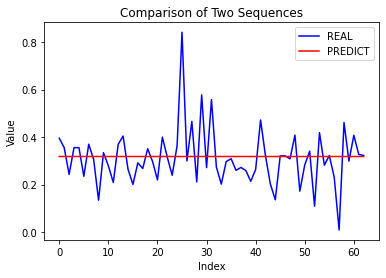

In [21]:
plot_comparison(Y_test,test_predictions)

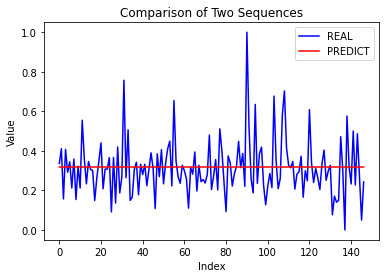

In [18]:
plot_comparison(Y_train,train_outputs)